# Problem 4

In [1]:
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

Populating the interactive namespace from numpy and matplotlib


### Defining Constants

First, we define the necessary coefficients. $b5$ are the coefficients to $5^{th}$ order and $b4$ are those to $4^{th}$ order.

In [2]:
cs = [0.0,1/4,3/8,12/13,1,1/2]
b5 = [16/135,0.0,6656/12825,28561/56430,-9/50,2/55]
b4 = [25/216,0.0,1408/2565,2197/4104,-1/5,0]
aa = [[0.0,0.0,0.0,0.0,0.0,0.0],
      [1/4,0.0,0.0,0.0,0.0,0.0],
      [3/32,9/32,0.0,0.0,0.0,0.0],
      [1932/2197,-7200/2197,7296/2197,0.0,0.0,0.0],
      [439/216,-8.0,3680/513,-845/4104,0.0,0.0],
      [-8/27,2.0,-3544/2565,1859/4104,-11/40,0.0]]

### Functions needed to evolve ODE's

The following function computes the update step according to the Runge-Kutta-Fehlberg method. The error term that it returns is the difference between those calculated to fifth and fourth orders.

In [3]:
def RKF_update(ys,fs,h,t):
    N = len(ys)
    s = 6 #following Wikipedia's notation
    k = zeros((s,N),type(ys))
    k[0] = fs(t,ys)
    for i in range(1,s):
        ystep = zeros(N,type(ys))
        for j in range(i):
            ystep += aa[i][j]*k[j]
        k[i] = fs((t+(cs[i]*h)),(ys+(h*ystep)))
    o5term = zeros(N,type(ys))
    o4term = zeros(N,type(ys))
    for j in range(s):
        o5term += b5[j]*k[j]
        o4term += b4[j]*k[j]
    ynew = ys + h*o5term
    yerr = h*abs(o5term-o4term)
    
    return ynew,yerr

The following function enables us to dynamically change the step size reuired for the computation.

In [4]:
def step_adjust(ys,yerrs,h,rtol=1.0e-8,atol=1.0e-8):
    max_scale = 0.0
    N = len(ys)
    for i in range(N):
        scale = yerrs[i]/(atol + rtol*abs(ys[i]))
        max_scale = max(max_scale,scale)
        
    if max_scale > 2.0 :
        retry = 1
    else:
        retry = 0
        
    hnew = h/(max_scale)**(1/6) #5th order method
    
    if (hnew >= 2.0*h):
        hnew = 2.0*h
    elif (hnew <= h/2.0):
        hnew = h/2.0
        
    return hnew,retry

This stepper function evolves the ODE between $t_0$ and $t_1$ with the last step of the evolution landing exactly on $t_1$.

In [5]:
def evolution(fs,t0,t1,ys0,atol=1.0e-8,rtol=1.0e-8):
    t = t0
    ys = ys0
    h = (t1-t0)/100.0
    keep_going = 1
    
    while (keep_going):
        if ((t+h) > t1):
            h = t1 - t
            keep_going = 0
            
        ys_new, ys_err = RKF_update(ys,fs,h,t)
        h_new, retry = step_adjust(ys_new,ys_err,h)
        
        if (retry):
            h = h_new
            keep_going = 1
        else:
            ys = ys_new
            t = t + h
            h = h_new
        
    return ys

### Basic Trial - Exp

As a trial, we use this to get the exponential function, which satisfies the ODE $y' = -y$.

We first solve this for a single variable, and then two variables $y_1' = -y_1$ and $y_2' = -y_2$ (with difference initial conditions, just as a proof of concept that our solving routine works for systems of ODE's. We also plot the errors for each case between the computed and analytical solutions.

In [6]:
def f_exp(t,y):
    return -y

In [7]:
ts = linspace(0,10.0,1001)
ys = [array([1.0])]
for i in range(1,len(ts)):
    y = evolution(f_exp,ts[i-1],ts[i],ys[i-1])
    ys.append(y)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


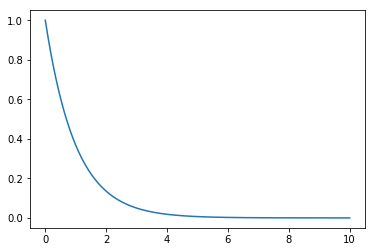

In [8]:
plot(ts,ys)

In [9]:
ycal = []
for i in range(len(ys)):
    ycal.append(ys[i][0])

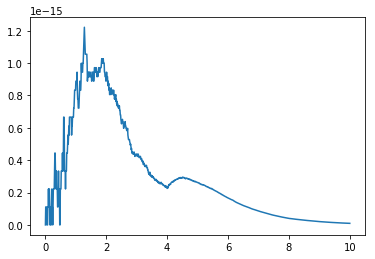

In [10]:
errs = abs(ycal-exp(-ts))
plot(ts,errs)

In [11]:
ts = linspace(0,10.0,1001)
xs = [array([1.0,2.0])]
for i in range(1,len(ts)):
    x = evolution(f_exp,ts[i-1],ts[i],xs[i-1])
    xs.append(x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


In [12]:
x1 = []
x2 = []
for i in range(len(xs)):
    x1.append(xs[i][0])
    x2.append(xs[i][1])

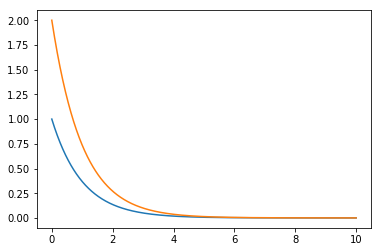

In [13]:
plot(ts,x1)
plot(ts,x2)

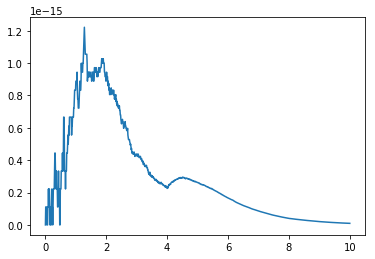

In [14]:
errs = abs(x1-exp(-ts))
plot(ts,errs)

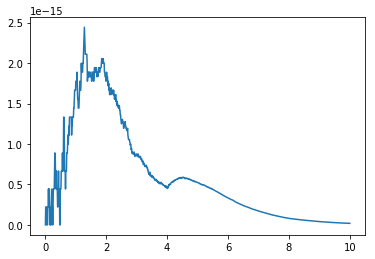

In [15]:
errs = abs(x2-(2.0*exp(-ts)))
plot(ts,errs)

In each case, barring the very odd shape of the error curve, the errors are of the order of machine precisions.

---
## Lorenz System

The Lorenz system of equations read: 
$$
x' = \sigma(y-x)
$$
$$
y' = x(\rho - z) -y
$$
$$
z' = xy -\beta z
$$

We take the parameters to be $\sigma=10,\rho=28,$ and $\beta=8/3$.


In [16]:
def Lorenz(t,xx,sigma=10.0,rho=28.0,beta=8.0/3.0):
    X = xx[0]
    Y = xx[1]
    Z = xx[2]
    dxdt = sigma*(Y-X)
    dydt = X*(rho - Z) - Y 
    dzdt = X*Y - (beta*Z)
    evolve = np.array([dxdt,dydt,dzdt])
    
    return evolve

### Fixed points
The points $(0,0,0)$ $ (\pm\sqrt{\beta(\rho - 1)},\pm\sqrt{\beta(\rho - 1)},\rho - 1)$ are fixed points. So if we start the evolution at any of these point, the system will stay at these points.

In [17]:
ts = linspace(0.0,10.0,1001)
xx = [array([0.0,0.0,0.0])]
for i in range(1,len(ts)):
    x = evolution(Lorenz,ts[i-1],ts[i],xx[i-1])
    xx.append(x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5, 1.0, 'Plot of x,y,z vs t')

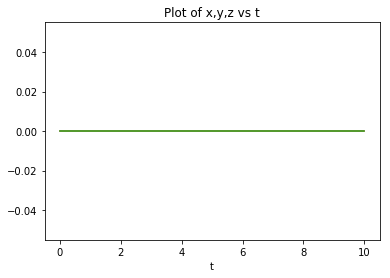

In [19]:
X0 = []
Y0 = []
Z0 = []
for i in range(len(xx)):
    X0.append(xx[i][0])
    Y0.append(xx[i][1])
    Z0.append(xx[i][2])
    
plot(ts,X0)
plot(ts,Y0)
plot(ts,Z0)
xlabel("t")
title("Plot of x,y,z vs t")

In [20]:
ts = linspace(0.0,10.0,1001)
Xx = [array([sqrt(72.0),sqrt(72),27.0])]
for i in range(1,len(ts)):
    x = evolution(Lorenz,ts[i-1],ts[i],Xx[i-1])
    Xx.append(x)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5, 1.0, 'Plot of x,y,z vs t')

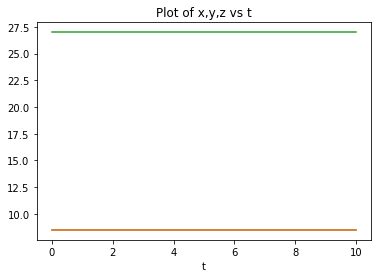

In [21]:
Xx0 = []
Yy0 = []
Zz0 = []
for i in range(len(Xx)):
    Xx0.append(Xx[i][0])
    Yy0.append(Xx[i][1])
    Zz0.append(Xx[i][2])
    
plot(ts,Xx0)
plot(ts,Yy0)
plot(ts,Zz0)
xlabel("t")
title("Plot of x,y,z vs t")

In the two plots above, we have plotted the values of $x, y,$ and $z$ as a function of time. We get a horizontal line indicating that these are fixed point.

### Orbits
Next, we will look at different orbits for different initial conditions.

In [22]:
ts = linspace(0.0,100.0,10001)
orbit = [array([sqrt(72.0),sqrt(72)+1.0e-5,27.0])] #small perturbation from fixed point
for i in range(1,len(ts)):
    x = evolution(Lorenz,ts[i-1],ts[i],orbit[i-1])
    orbit.append(x)

OX = []
OY = []
OZ = []
for i in range(len(orbit)):
    OX.append(orbit[i][0])
    OY.append(orbit[i][1])
    OZ.append(orbit[i][2])

Text(0.5, 0, 'z')

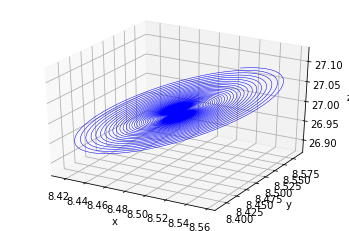

In [23]:
ax = plt.axes(projection='3d')
ax.plot3D(OX,OY,OZ,'blue',linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

This trajectory seems to follow a regular motion and converge to a limit cycle, but given enough time, it will show chaotic motion, as shown below.

In [24]:
ts = linspace(0.0,200.0,20001)
orbits = [array([sqrt(72.0),sqrt(72)+1.0e-5,27.0])] #small perturbation from fixed point
for i in range(1,len(ts)):
    x = evolution(Lorenz,ts[i-1],ts[i],orbits[i-1])
    orbits.append(x)

OoX = []
OoY = []
OoZ = []
for i in range(len(orbits)):
    OoX.append(orbits[i][0])
    OoY.append(orbits[i][1])
    OoZ.append(orbits[i][2])

Text(0.5, 0, 'z')

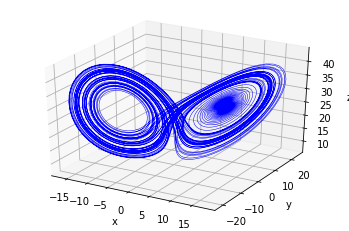

In [25]:
ax = plt.axes(projection='3d')
ax.plot3D(OoX,OoY,OoZ,'blue',linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [26]:
ts = linspace(0.0,100.0,10001)
xx3 = [array([-30.0,40.0,10.0])]
for i in range(1,len(ts)):
    #print(i)
    x = evolution(Lorenz,ts[i-1],ts[i],xx3[i-1])
    xx3.append(x)

X2 = []
Y2 = []
Z2 = []
for i in range(len(xx3)):
    X2.append(xx3[i][0])
    Y2.append(xx3[i][1])
    Z2.append(xx3[i][2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5, 0, 'z')

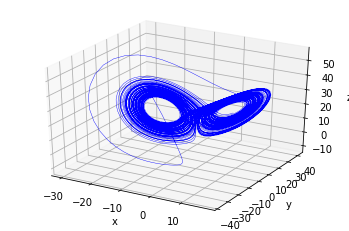

In [27]:
ax = plt.axes(projection='3d')
ax.plot3D(X2,Y2,Z2,'blue',linewidth=0.4)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

### Chaotic Orbits

Finally, we show the chaotic nature of the Lorenz system. We will first plot an attractor, and then slightly perturb the initial conditions to show the sensitivity to initial conditions.

In [28]:
ts = linspace(0.0,100.0,10001)
xx1 = [array([1.0,2.0,-4.0])]
for i in range(1,len(ts)):
    #print(i)
    x = evolution(Lorenz,ts[i-1],ts[i],xx1[i-1])
    xx1.append(x)

X = []
Y = []
Z = []
for i in range(len(xx1)):
    X.append(xx1[i][0])
    Y.append(xx1[i][1])
    Z.append(xx1[i][2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5, 0, 'z')

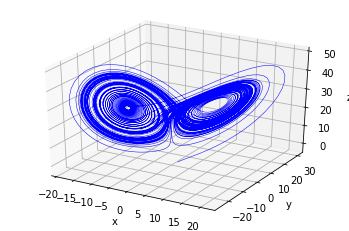

In [29]:
ax = plt.axes(projection='3d')
ax.plot3D(X,Y,Z,'blue',linewidth=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [30]:
ts = linspace(0.0,100.0,10001)
xx2 = [array([1.0+1.0e-15,2.0,-4.0])]
for i in range(1,len(ts)):
    #print(i)
    x = evolution(Lorenz,ts[i-1],ts[i],xx2[i-1])
    xx2.append(x)

X1 = []
Y1 = []
Z1 = []
for i in range(len(xx1)):
    X1.append(xx2[i][0])
    Y1.append(xx2[i][1])
    Z1.append(xx2[i][2])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


Text(0.5, 0, 'z')

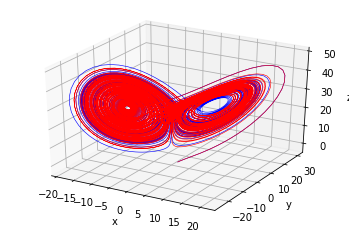

In [31]:
ax = plt.axes(projection='3d')
ax.plot3D(X,Y,Z,'blue',linewidth=0.6)
ax.plot3D(X1,Y1,Z1,'red',linewidth=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In the plot above, we see that the red and blue curves don't coincide. The "gaps" in the blue curve (two curves above) are filled byt the red curve "fills" these gaps. This shows the chaotic nature of the system - initially infinitesimally separated trajectories diverge.